In [1]:
from osgeo import gdal,ogr,gdal_array,gdalnumeric
import shapely.wkt
import shapely.affinity
from tqdm import tqdm
import pandas as pd
from pandas import set_option
import numpy as np
import cv2
from collections import Counter
import os
import osr
import geopandas as gpd
import matplotlib.pyplot as plt
from geopandas import *
# import rasterio as rio
# import rasterio.mask
from sklearn import model_selection
import pickle 
# from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

In [2]:
#定义读取矢量函数
def read_shp(shp_path):    
    vector = gpd.read_file(shp_path)
    return vector
#定义读取栅格函数
def read_raster(raster_path):
    
    data = gdal.Open(raster_path)
    im_width = data.RasterXSize    #栅格矩阵的列数
    im_height = data.RasterYSize   #栅格矩阵的行数        
    gt = data.GetGeoTransform()#仿射矩阵
    crs = data.GetProjection()#地图投影信息
    data_array = data.ReadAsArray(0,0,im_width,im_height)#转化为矩阵
    return data,data_array,gt,crs

In [5]:
#将面状要素
def geo2pixel(record,GeoTransform):
    """
    http://www.gdal.org/gdal_tutorial.html

    GeoTransform[0] /* top left x */
    GeoTransform[1] /* w-e pixel resolution */
    GeoTransform[2] /* 0 */
    GeoTransform[3] /* top left y */
    GeoTransform[4] /* 0 */
    """
    uper_left_x = float(GeoTransform[0])
    uper_left_y = float(GeoTransform[3])
    pixel_width = float(GeoTransform[1])
    pixel_height = float(GeoTransform[5])
    (mx, my) = (record[0], record[1])
    px = int((mx - uper_left_x) / pixel_width)  # x pixel
    py = int((my - uper_left_y) / pixel_height)  # y pixel
    return px,py
#根据矢量生成mask,再根据mask提取图像信息
def clip(poly,gt,data):
    
    minX,maxX = min(poly.envelope.exterior.coords.xy[0]),max(poly.envelope.exterior.coords.xy[0])
    minY,maxY = min(poly.envelope.exterior.coords.xy[1]),max(poly.envelope.exterior.coords.xy[1])

    uper_left_X, uper_left_Y = geo2pixel((minX,maxY),gt)
    lower_right_X, lower_right_Y = geo2pixel((maxX,minY),gt)

    pxWidth = int(lower_right_X - uper_left_X)
    pxHeight = int(lower_right_Y - uper_left_Y)
    #根据外接矩形裁剪
    clip = data.ReadAsArray(int(uper_left_X),int(uper_left_Y),int(pxWidth),int(pxHeight))

    gt2 = list(gt)
    gt2[0] = minX
    gt2[3] = maxY
    ext_pix = np.array([geo2pixel(points,gt2) for points in poly.exterior.coords])
    ext_pix = np.expand_dims(ext_pix,axis=0)
    mask = np.ones([pxHeight,pxWidth], np.uint8)

    mask = cv2.fillPoly(mask,ext_pix, 0)#介绍CV2.fillploy()
    clip = gdalnumeric.choose(mask, (clip, 0))
    return clip
#保存tif文件函数
def writeTiff(im_data,im_geotrans,im_proj,path):
    if 'int8' in im_data.dtype.name:
        datatype = gdal.GDT_Byte
    elif 'int16' in im_data.dtype.name:
        datatype = gdal.GDT_UInt16
    else:
        datatype = gdal.GDT_Float32
    if len(im_data.shape) == 3:
        im_bands, im_height, im_width = im_data.shape
    elif len(im_data.shape) == 2:
        im_data = np.array([im_data])
        im_bands, im_height, im_width = im_data.shape
#创建文件
    driver = gdal.GetDriverByName("GTiff")
    dataset = driver.Create(path, int(im_width), int(im_height), int(im_bands), datatype)
    if(dataset!= None):
        dataset.SetGeoTransform(im_geotrans) #写入仿射变换参数
        dataset.SetProjection(im_proj) #写入投影
    for i in range(im_bands):
        dataset.GetRasterBand(i+1).WriteArray(im_data[i])
    del dataset

In [6]:
#把所有根据矢量样本提取的特征参数统一为能够训练的标准格式
def concat_clip_data(shp_files,raster):
    shp_list = [i for i in shp_files if i.endswith('.shp')== True]
    out = []
    for i in shp_list:
        vector = read_shp(os.path.join(r'./使用数据/分类矢量',i))
        #
        class_ = vector['class'].unique()

        all_list = []
        for j in range(len(vector)):

            if j >= len(vector) or j < -j:
                continue
            ploy = vector.iloc[j]['geometry']
            clip_array = clip(ploy,gt,raster)
            #判断裁剪后的结果的维度是否符合（w,h,channel）的格式
            if clip_array.ndim != 3:
                continue
            lst = []
            for n in range(clip_array.ndim+1):
                b = pd.DataFrame(clip_array[n].flatten())
    #             print(len(b),type(b))
                lst.append(b)

            lab = pd.DataFrame([class_]*(clip_array.shape[1]*clip_array.shape[2]))
            lst.append(lab)
            ds = pd.concat(lst,axis=1,ignore_index=True)

            all_list.append(ds)
        all_ds = pd.concat(all_list,axis=0,ignore_index=True)

        out.append(all_ds)
    out = pd.concat(out,axis=0,ignore_index=True)
    # print(out.head(-10))
    # print(len(out))
    return out

开始训练模型

In [7]:
#定义当前工作目录
work_path = r'./'
#读取栅格影像
data,data_array,gt,crs = read_raster(r'./使用数据/分类栅格/裁剪太子山影像.tif')
#查看矢量文件
shp_files = os.listdir(r'./使用数据/分类矢量')
print([i for i in shp_files if i.endswith('.shp')== True])


['DAOLU.shp', 'JUMINQU.shp', 'LUODI.shp', 'NONGTIAN.shp', 'SENLIN.shp', 'SHUIYU.shp']


In [8]:
#调用concat_clip_data函数对每个矢量提取的数据进行合并
out = concat_clip_data(shp_files,data)
#随机查看
out.sample(10)

,0,1,2,3,4
45499,0,0,0,0,1
47631,0,0,0,0,1
46985,0,0,0,0,1
10078,0,0,0,0,1
46736,0,0,0,0,1
3997,404,284,226,333,1
54366,0,0,0,0,1
128969,0,0,0,0,6
64671,0,0,0,0,2
43389,0,0,0,0,1


In [9]:
#删除0填充的样本
out_train = out.drop(out[(out[0] == 0) & (out[1] == 0)&(out[2] == 0)&(out[3] == 0)].index)
#随机查看样本
out_train.sample(10)

,0,1,2,3,4
73512,434,325,299,337,4
125642,386,255,166,88,6
78438,394,274,202,276,4
118680,411,297,196,90,6
108304,377,251,162,275,5
106223,372,244,156,271,5
99280,359,220,137,222,5
85128,420,308,296,278,4
99897,369,240,149,227,5
99954,367,237,149,270,5


In [10]:
X = out_train.iloc[:,0:4] #选取前4个波段作为特征
Y = out_train.iloc[:,-1]#最后一列为标签
train_data,test_data,train_label,test_label = model_selection.train_test_split(X,Y, random_state=1, train_size=0.7,test_size=0.3)#将数据分割为训练集与测试集

In [11]:
train_label

96426     5
130759    6
93110     5
125652    6
66104     2
         ..
124667    6
103585    5
62876     2
73254     4
104214    5
Name: 4, Length: 34166, dtype: int64

In [12]:
#查看训练集
train_data.head()

,0,1,2,3
96426,357,227,141,249
130759,383,247,156,86
93110,369,235,153,263
125652,388,255,164,88
66104,396,270,195,268


In [13]:
#数据标准化，提高模型泛化能力
def data_processing(data):
    ss_x = StandardScaler().fit(data)
    StandardScaler_data = ss_x.transform(data)
    return StandardScaler_data

In [14]:
train_data = data_processing(train_data)
test_data = data_processing(test_data)
#查看标准化后的训练集
train_data

array([[-1.25960453, -1.23282157, -1.0957493 , -0.0078631 ],
       [-0.44826707, -0.70035567, -0.84736108, -2.03330566],
       [-0.88514109, -1.01983521, -0.89703873,  0.16610129],
       ...,
       [ 1.39284488,  1.21652156,  1.30533683, -0.14454941],
       [ 0.83114971,  1.0301585 ,  1.22254076,  0.47675199],
       [-1.25960453, -1.49905452, -1.21166381, -0.66644258]])

In [15]:
for_train_data = pd.DataFrame(train_data)
for_train_data['label']=train_label.values
for_train_data=for_train_data.rename(columns={0:'band1',1:'band2',2:'band3',3:'band4'})
for_train_data

,band1,band2,band3,band4,label
0,-1.259605,-1.232822,-1.095749,-0.007863,5
1,-0.448267,-0.700356,-0.847361,-2.033306,6
2,-0.885141,-1.019835,-0.897039,0.166101,5
3,-0.292241,-0.487369,-0.714887,-2.008454,6
4,-0.042598,-0.088020,-0.201552,0.228231,2
...,...,...,...,...,...
34161,-0.105009,-0.167890,-0.598973,-1.983602,6
34162,-1.384426,-1.392561,-1.211664,0.240657,5
34163,1.392845,1.216522,1.305337,-0.144549,2
34164,0.831150,1.030158,1.222541,0.476752,4


In [16]:
# 保存模型
def save_model(save_path,model,model_name):
    #以读二进制的方式打开文件
    file = open(os.path.join(save_path,model_name), "wb")
    #将模型写入文件：
    pickle.dump(model, file)
    #最后关闭文件：
    file.close()
    return 
# 读取模型
def load_model(model_path,model_name):
    #以读二进制的方式打开文件
    file = open(os.path.join(model_path,model_name), "rb")
    #把模型从文件中读取出来
    model = pickle.load(file)
    #关闭文件
    file.close()
    return
#预测
def predict_img(model_path,raster_Path,out_path):

    data,data_array,gt,crs = read_raster(raster_Path)

    #调用保存好的模型
    #以读二进制的方式打开文件
    file = open(model_path, "rb")
    #把模型从文件中读取出来
    model = pickle.load(file)
    #关闭文件
    file.close()
    #用读入的模型进行预测
    #  在与测试前要调整一下数据的格式
    array = np.zeros((data_array.shape[0],data_array.shape[1]*data_array.shape[2]))
    for i in range(data_array.shape[0]):
        array[i] = data_array[i].flatten() 
    array = array.swapaxes(0,1)
    #  对调整好格式的数据进行预测
    array = data_processing(array)
    pred = model.predict(array)
    #  同样地，我们对预测好的数据调整为我们图像的格式
    # pred = pred.reshape(Landset_data.shape[1],Landset_data.shape[2])*255
    pred = pred.reshape(data_array.shape[1],data_array.shape[2])
    pred = pred.astype(np.uint8)

    #  将结果写到tif图像里
    writeTiff(pred,gt,crs,out_path)
    return pred

    
    

In [17]:
from sklearn.ensemble import RandomForestClassifier

In [18]:
plt.rcParams['font.sans-serif'] =[ 'SimHei']
plt.rcParams['axes.unicode_minus'] = False

训练集： 0.9977755663525142
测试集： 0.9087618657378952


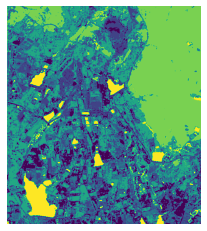

In [20]:
#构建随机森林分类模型
RF_classifier = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')
RF_classifier.fit(train_data, train_label.ravel())#ravel函数将数据拉伸到一维


# 计算准确率
print("训练集：",RF_classifier.score(train_data,train_label))
print("测试集：",RF_classifier.score(test_data,test_label))

# 保存模型
save_model(os.path.join(work_path,'输出数据'),RF_classifier,'model_rf.pickle')

#预测模型
model_path = os.path.join(work_path,'输出数据','model_rf.pickle')
raster_Path = os.path.join(work_path,'使用数据','分类栅格','裁剪太子山影像.tif')
out_path = os.path.join(work_path,'输出数据','pred_rf.tif')
pred_img = predict_img(model_path,raster_Path,out_path)
#查看分类情况
# plt.text(x = -10,y = -30, s = '行')
# plt.text(x = 660,y = 720, s = '列')
plt.axis('off')
plt.imshow(pred_img)
plt.savefig(r'g:\python林业资源\出图/分类RF.png',dpi=300)
plt.show()


In [ ]:
#调用sklearn库中的指标求解
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [ ]:
#给出分类结果
y_pred = RF_classifier.predict(test_data)
y_true = test_label
print("accuracy_score:", accuracy_score(y_true, y_pred))
print("precision_score:", metrics.precision_score(y_true, y_pred, average='micro'))
print("recall_score:", metrics.recall_score(y_true, y_pred, average='micro'))
print("f1_score:", metrics.f1_score(y_true, y_pred, average='micro'))
print("f0.5_score:", metrics.fbeta_score(y_true, y_pred, beta=0.5, average='micro'))
print("f2_score:", metrics.fbeta_score(y_true, y_pred, beta=2.0, average='micro'))
print(classification_report(y_true=y_true, y_pred=y_pred))

In [ ]:
from sklearn import neighbors

In [ ]:
#构建K邻域分类模型
KNN_classifier = neighbors.KNeighborsClassifier(algorithm='kd_tree')
KNN_classifier.fit(train_data, train_label.ravel())
# 计算准确率
print("训练集：",KNN_classifier.score(train_data,train_label))
print("测试集：",KNN_classifier.score(test_data,test_label))

# 保存模型
save_model(os.path.join(work_path,'输出数据'),KNN_classifier,'model_knn.pickle')
#预测模型
model_path = os.path.join(work_path,'输出数据','model_knn.pickle')
raster_Path = os.path.join(work_path,'使用数据','分类栅格','裁剪太子山影像.tif')
out_path = os.path.join(work_path,'输出数据','pred_knn.tif')
pred_img = predict_img(model_path,raster_Path,out_path)
#查看分类情况
plt.axis('off')
plt.imshow(pred_img)
# plt.savefig(r'F:\python林业资源\出图/分类KNN.png',dpi=300)
plt.show()

In [ ]:
#给出分类结果
y_pred = KNN_classifier.predict(test_data)
y_true = test_label
print("accuracy_score:", accuracy_score(y_true, y_pred))
print("precision_score:", metrics.precision_score(y_true, y_pred, average='micro'))
print("recall_score:", metrics.recall_score(y_true, y_pred, average='micro'))
print("f1_score:", metrics.f1_score(y_true, y_pred, average='micro'))
print("f0.5_score:", metrics.fbeta_score(y_true, y_pred, beta=0.5, average='micro'))
print("f2_score:", metrics.fbeta_score(y_true, y_pred, beta=2.0, average='micro'))
print(classification_report(y_true=y_true, y_pred=y_pred))

In [ ]:
from sklearn import tree

In [ ]:
#构建决策树分类模型
Tree_classifier = tree.DecisionTreeClassifier(criterion='entropy')
Tree_classifier.fit(train_data, train_label.ravel())
# 计算准确率
print("训练集：",Tree_classifier.score(train_data,train_label))
print("测试集：",Tree_classifier.score(test_data,test_label))
# 保存模型
save_model(os.path.join(work_path,'输出数据'),Tree_classifier,'model_tree.pickle')
#预测模型
model_path = os.path.join(work_path,'输出数据','model_tree.pickle')
raster_Path = os.path.join(work_path,'使用数据','分类栅格','裁剪太子山影像.tif')
out_path = os.path.join(work_path,'输出数据','pred_tree.tif')
pred_img = predict_img(model_path,raster_Path,out_path)
#查看分类情况
plt.axis('off')
plt.imshow(pred_img)
# plt.savefig(r'F:\python林业资源\出图/分类决策树.png',dpi=300)
plt.show()

In [ ]:
#给出分类结果
y_pred = Tree_classifier.predict(test_data)
y_true = test_label
print("accuracy_score:", accuracy_score(y_true, y_pred))
print("precision_score:", metrics.precision_score(y_true, y_pred, average='micro'))
print("recall_score:", metrics.recall_score(y_true, y_pred, average='micro'))
print("f1_score:", metrics.f1_score(y_true, y_pred, average='micro'))
print("f0.5_score:", metrics.fbeta_score(y_true, y_pred, beta=0.5, average='micro'))
print("f2_score:", metrics.fbeta_score(y_true, y_pred, beta=2.0, average='micro'))
print(classification_report(y_true=y_true, y_pred=y_pred))

In [ ]:
from sklearn import svm

In [ ]:
#构建持向量机分类模型
SVM_classifier = svm.SVC()
SVM_classifier.fit(train_data, train_label.ravel())
# 计算准确率
print("训练集：",SVM_classifier.score(train_data,train_label))
print("测试集：",SVM_classifier.score(test_data,test_label))
# 保存模型
save_model(os.path.join(work_path,'输出数据'),SVM_classifier,'model_svm.pickle')
#预测模型
model_path = os.path.join(work_path,'输出数据','model_svm.pickle')
raster_Path = os.path.join(work_path,'使用数据','分类栅格','裁剪太子山影像.tif')
out_path = os.path.join(work_path,'输出数据','pred_svm.tif')
pred_img = predict_img(model_path,raster_Path,out_path)
#查看分类情况
# plt.text(x = -10,y = -30, s = '行')
# plt.text(x = 660,y = 720, s = '列')
plt.axis('off')
plt.imshow(pred_img)
# plt.savefig(r'F:\python林业资源\出图/分类svm.png',dpi=300)
plt.show()

In [ ]:
#给出分类结果
y_pred = SVM_classifier.predict(test_data)
y_true = test_label
print("accuracy_score:", accuracy_score(y_true, y_pred))
print("precision_score:", metrics.precision_score(y_true, y_pred, average='micro'))
print("recall_score:", metrics.recall_score(y_true, y_pred, average='micro'))
print("f1_score:", metrics.f1_score(y_true, y_pred, average='micro'))
print("f0.5_score:", metrics.fbeta_score(y_true, y_pred, beta=0.5, average='micro'))
print("f2_score:", metrics.fbeta_score(y_true, y_pred, beta=2.0, average='micro'))
print(classification_report(y_true=y_true, y_pred=y_pred))